In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['spam.csv']


In [8]:
df = pd.read_csv('../input/spam.csv',delimiter=',',encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


Let's drop the unnecessary columns.

In [9]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],axis=1,inplace=True)

In [10]:
df.shape

(5572, 2)

Text(0.5,1,'Number of ham and spam messages')

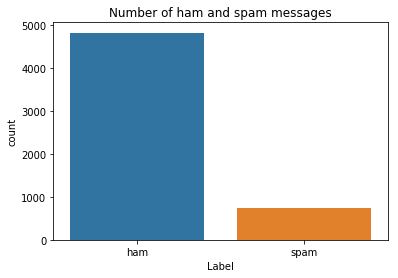

In [4]:
#plot the ham and spam messages to understand the distribution
sns.countplot(df.v1)
plt.xlabel('Label')
plt.title('Number of ham and spam messages')

In [5]:
X = df.v2
Y = df.v1
#label encoding for Y
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [17]:
#split into train and test sets
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.20)

## Processing Data

In [18]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [19]:
inputs = Input(name='inputs',shape=[max_len])
layer = Embedding(max_words,50,input_length=max_len)(inputs)
layer = LSTM(64)(layer)
layer = Dense(256,name='FC1')(layer)
layer = Activation('relu')(layer)
layer = Dropout(0.5)(layer)
layer = Dense(1,name='out_layer')(layer)
layer = Activation('sigmoid')(layer)
model = Model(inputs=inputs,outputs=layer)

In [20]:
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 150)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_3 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257       
__________

In [23]:
model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Train on 3565 samples, validate on 892 samples
Epoch 1/10
3565/3565 [==============================] - 12s 3ms/step - loss: 0.0136 - acc: 0.9961 - val_loss: 0.0832 - val_acc: 0.9854
Epoch 2/10
3565/3565 [==============================] - 12s 3ms/step - loss: 0.0110 - acc: 0.9964 - val_loss: 0.0843 - val_acc: 0.9854


In [24]:
#processing test data
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [25]:
#evaluation of our model
accr = model.evaluate(test_sequences_matrix,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

1115/1115 [==============================] - 2s 2ms/step
Test set
  Loss: 0.110
  Accuracy: 0.979
